In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_4.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["matrixSize"] = dataFrame["matrixSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Matrix sizes:", sorted(dataFrame["matrixSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 250
Modes: ['blockRow' 'cannon']
Matrix sizes: [240, 480, 720, 960, 1200]
Process counts: [1, 4, 9, 16, 25]


,testType,matrixSize,numProcesses,mode,timeSeconds,checksum,runIndex,mpiEnv
0,MPI_4,240,1,blockRow,0.018620,3.452627e+06,4,SLURM_NTASKS=1;JOBID=13113
1,MPI_4,240,1,cannon,0.030889,3.470858e+06,4,SLURM_NTASKS=1;JOBID=13118
2,MPI_4,240,1,blockRow,0.020118,3.445610e+06,3,SLURM_NTASKS=1;JOBID=13112
3,MPI_4,240,1,blockRow,0.020110,3.466393e+06,5,SLURM_NTASKS=1;JOBID=13114
4,MPI_4,240,1,cannon,0.031419,3.457579e+06,1,SLURM_NTASKS=1;JOBID=13115
5,MPI_4,240,1,blockRow,0.019564,3.467834e+06,2,SLURM_NTASKS=1;JOBID=13111
6,MPI_4,240,1,cannon,0.030768,3.454433e+06,3,SLURM_NTASKS=1;JOBID=13117
7,MPI_4,240,1,blockRow,0.018603,3.454429e+06,1,SLURM_NTASKS=1;JOBID=13110


In [3]:
groupedFrame = dataFrame.groupby(["mode","matrixSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","matrixSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,mode,matrixSize,numProcesses,median,mean,std,count
0,blockRow,240,1,0.019564,0.019403,0.000757,5
1,blockRow,240,4,0.007873,0.009127,0.002410,5
2,blockRow,240,9,0.009239,0.009255,0.001075,5
3,blockRow,240,16,0.013778,0.013877,0.001401,5
4,blockRow,240,25,0.056577,0.056618,0.001359,5
5,blockRow,480,1,0.115894,0.116222,0.001690,5
6,blockRow,480,4,0.041265,0.041827,0.001410,5
7,blockRow,480,9,0.039765,0.041938,0.007479,5
8,blockRow,480,16,0.049784,0.049508,0.003541,5
9,blockRow,480,25,0.085782,0.084546,0.002674,5


In [4]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, matrixSizeVal), subFrame in groupedDf.groupby(["mode","matrixSize"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,matrixSize,numProcesses,median,mean,std,count,speedup,efficiency
0,blockRow,240,1,0.019564,0.019403,0.000757,5,1.000000,1.000000
1,blockRow,240,4,0.007873,0.009127,0.002410,5,2.484949,0.621237
2,blockRow,240,9,0.009239,0.009255,0.001075,5,2.117545,0.235283
3,blockRow,240,16,0.013778,0.013877,0.001401,5,1.419945,0.088747
4,blockRow,240,25,0.056577,0.056618,0.001359,5,0.345794,0.013832
5,blockRow,480,1,0.115894,0.116222,0.001690,5,1.000000,1.000000
6,blockRow,480,4,0.041265,0.041827,0.001410,5,2.808530,0.702133
7,blockRow,480,9,0.039765,0.041938,0.007479,5,2.914473,0.323830
8,blockRow,480,16,0.049784,0.049508,0.003541,5,2.327937,0.145496
9,blockRow,480,25,0.085782,0.084546,0.002674,5,1.351029,0.054041


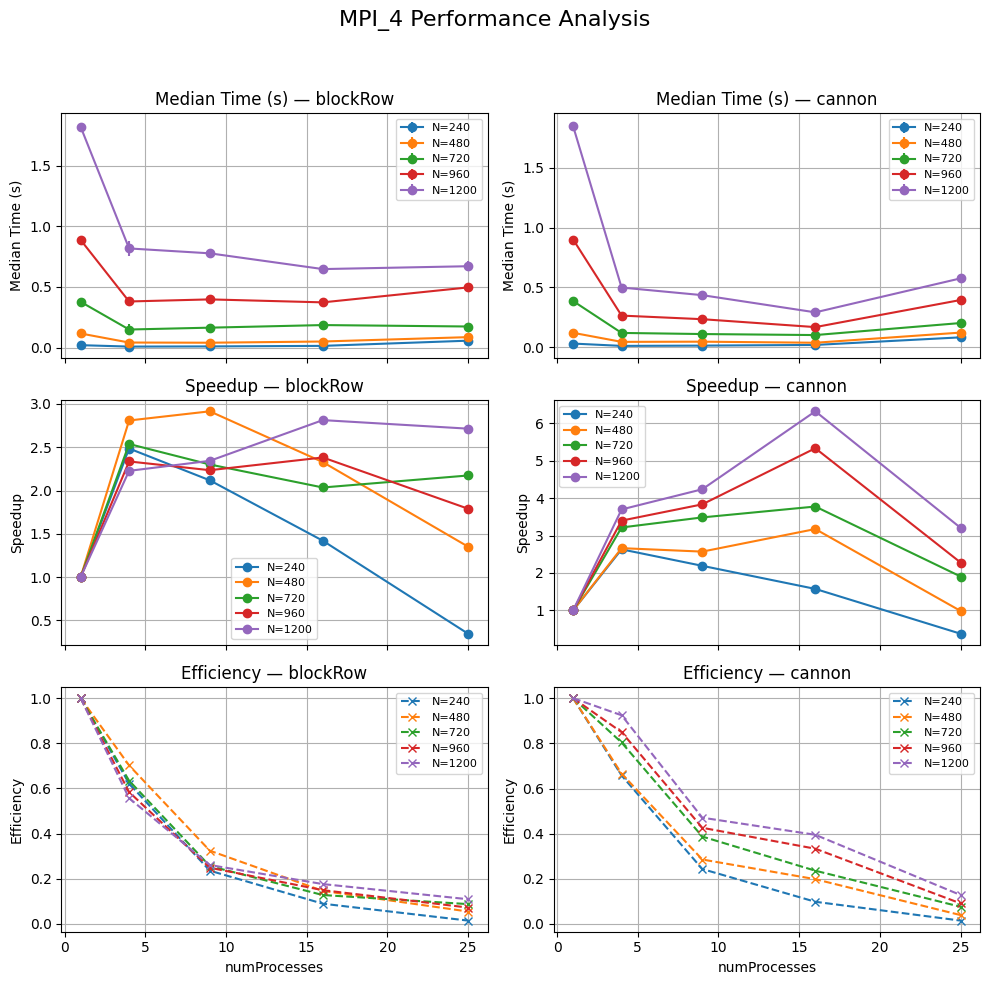

In [5]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

matrixSizes = sorted(perfFrame["matrixSize"].unique())

fig, axes = plt.subplots(len(metrics), len(modes), figsize=(5 * max(1, len(modes)), 10), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for matrixSizeVal in matrixSizes:
            subFrame = perfFrame[(perfFrame["mode"] == modeVal) & (perfFrame["matrixSize"] == matrixSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            anyPlotted = True
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values if "std" in subFrame.columns else None
                if yerr is not None:
                    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={matrixSizeVal}")
                else:
                    ax.plot(x, y, marker='o', linestyle='-', label=f"N={matrixSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={matrixSizeVal}")

        if not anyPlotted:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == len(metrics) - 1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("MPI_4 Performance Analysis", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [6]:
summaryRows = []
for (modeVal, matrixSizeVal), sub in perfFrame.groupby(["mode","matrixSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "matrixSize": matrixSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Proc": medianAtOne
    })

summaryFrame = pd.DataFrame(summaryRows).sort_values(["mode","matrixSize"])
display(summaryFrame)


,mode,matrixSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Proc
0,blockRow,240,4,2.484949,0.621237,0.019564
1,blockRow,480,9,2.914473,0.323830,0.115894
2,blockRow,720,4,2.537102,0.634276,0.377087
3,blockRow,960,16,2.381458,0.148841,0.887186
4,blockRow,1200,16,2.812903,0.175806,1.819892
5,cannon,240,4,2.630891,0.657723,0.031205
6,cannon,480,16,3.173636,0.198352,0.120979
7,cannon,720,16,3.775333,0.235958,0.386209
8,cannon,960,16,5.333493,0.333343,0.900331
9,cannon,1200,16,6.320435,0.395027,1.845782
